In [3]:
import pandas as pd
import numpy as np
import itertools
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import scipy.stats as stats

In [2]:
import stylised_facts_data_utilities.TukeyGH as tukey

In [112]:
locParams = np.linspace( -3.5, 3.5, 1 )
scaleParams = np.linspace( 0.1, 3.5, 1 )
gParams = (-2.25, -1.5, 1.5, 2.25)
hParams = 10**np.linspace( -3, -1, 3 )


In [113]:
def z2gh(z, A, B, g, h, c=0.8):
    """
    x= A + B*(1+c*tanh(g*z/2))* z*exp(0.5*h*z^2)
    :param z:
    :param A:
    :param B:
    :param g:
    :param h:
    :param c:
    :return:
    """
    term1 = 1 + c*np.tanh(g*z /2.0)
    term2 = z * np.exp(0.5 * h * z **2)
    if g==0:
        term1 = 1
    if h ==0:
        term2 = z
    return A + B * term1 * term2

In [114]:
def qgh(p, A, B, g, h, c=0.8):
    '''
    g- and h- distribution functions
    Density, distribution function, quantile function and random generation for the generalised g- and h- distribution
    uses stats.norm.ppf which is the percent point function - inversion of CDF and returns percentiles
    :param p: vector of probabilities
    :param A: vector of loc params
    :param B: vector of scale params. must be positive
    :param g: vector of g params
    :param h: vector of h params
    :param c: default is 0.8
    :return:
    '''
    return z2gh(stats.norm.ppf(p), A, B, g, h, c)

In [115]:
def rgh(n, A, B, g, h, c=0.8):
    """
    random sampling from g, h
    :param n:
    :param A:
    :param B:
    :param g:
    :param h:
    :param c:
    :return:
    """
    return z2gh(stats.norm.rvs(size=n), A, B, g, h, c)

In [116]:
Y  = rgh(int(i), 0.5, -0.5, -2, 0.1)

In [117]:
for i in (100,200,300, 500, 1000):
    print(rgh(int(i), 0.5, -0.5, 12.5, 0.5))

[ 0.54638554  0.65962704 -0.49165254  0.53187286  0.56068225  0.23394941
  0.63525346  0.57856577  0.4542506   2.00715472  0.57633456  0.42124932
 -0.34707988  0.04278368 -0.05852247 -2.06348621 -0.23829371  0.66605174
  0.08744991  0.07808949 -0.90971356  1.02764094  0.1000754  -0.58125473
 -0.83117653 -0.17232486  0.61265767  0.56887882  0.14381396 -2.50774549
  0.54834833 -1.1033259   0.57079443  0.29682883  0.555938    0.52994632
  0.10778605  0.58592494  0.44115467 -0.28817133  0.75687127 -3.75649005
  0.56739697  0.61698635 -0.72763261  0.45334373  0.59752827  0.15925352
 -1.37659207 -1.56110408 -0.56911322  0.6358393   0.49759217  0.58706497
 -0.45954135 -0.13797891  0.52942592  0.50682554 -1.43655297  0.51606512
  0.31601922  0.35923712  0.39779181  0.86287513 -4.00811606  0.52946265
 -1.01130114 -0.10634309 -0.08404398  0.61884274  0.5934594   0.54734227
 -0.15764107 -0.40136773  0.32827675  0.18136868  0.50656564  0.52847231
 -0.81191828 -1.87200293  0.54522278  0.57461298 -0

In [118]:
paramList = pd.DataFrame( list( itertools.product(locParams, scaleParams, gParams, hParams ) ),
                        columns=['loc', 'scale', 'g', 'h'])

In [120]:
def generateTukeyDistribution( loc, scale, g, h, nSamples):
    z = np.random.normal( size =(nSamples,) )
    return tukey.qpk(z, loc, scale, g, h)

In [121]:
results = []
for _, params in tqdm( paramList.iterrows() ):
    Y =generateTukeyDistribution(nSamples=5000, **params.to_dict())
    estimatedParams = tukey.estimateTukeyDistribution( Y )
    estimatedParams = {'%s_estimated' % k : v for k, v in estimatedParams.items()}
    
    params = params.to_dict()
    params.update( estimatedParams )
    results += [ pd.DataFrame([params]) ]
results = pd.concat(results, axis=0, ignore_index=True)
for param in ['g', 'h', 'loc', 'scale']:
    results['%s_diff' % param] = results['%s_estimated' % param] -results['%s' % param]

In [122]:
Y = generateTukeyDistribution(loc = params['loc'],
                              scale = params['scale'],
                              g = params['g'],
                              h = params['h'],
                              nSamples=5000)

## Rayleigh

In [131]:
Y_rayleigh = np.random.normal( 50, size = (10000, ))
estimatedParams = tukey.estimateTukeyDistribution( Y_rayleigh )

In [134]:
Y_sampled = generateTukeyDistribution( loc=estimatedParams['loc'], 
                                       scale=estimatedParams['scale'], g=estimatedParams['g'], 
                                       h=estimatedParams['h'],
                                      nSamples = 10000,)

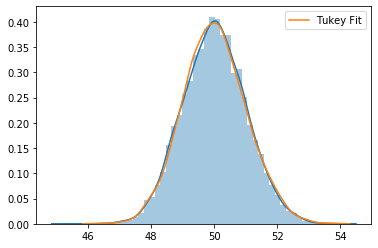

In [135]:
fig, ax =plt.subplots(1, 1)
sns.distplot(Y_rayleigh)
sns.distplot(Y_sampled, ax=ax, hist= False, label='Tukey Fit')